In [1]:
import cairo
import math, cmath
import networkx as nx # graph tools
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.interpolate import griddata

from matplotlib.pylab import rcParams

%matplotlib inline

In [2]:
rcParams['figure.figsize'] = 13, 13  # that's default image size for this interactive session

## Tiling classes

### Tiling
A parent class holding general infos about a tiling (its name), and class methods to print patches of the tilings using Cairo.
Child class will contain infos about the prototiles specifically used by the tiling they describe, as well as methods to build patches of the tiling.

### A5
The class of the Ammann-Beenker A5 tiling.

In [3]:
class Tiling:
    """ generate quasiperiodic tilings of the plane """
    
    # set of tiles used as basic building blocks of the tiling
    _prototiles = []
    
    def __init__(self, type):
        self._type = type
        
        # default basis vectors
        self._basis = np.identity(4)
        
        # default cairo surface
        self._surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 100, 100)
        # default cairo context
        self._cr = cairo.Context(self._surface)
    
    def get_prototiles(self):
        return self._prototiles
    
    # create a Cairo surface of resolution IMAGE_SIZE, and covering a square of half-length scaling centered at (0,0)
    def create_surface(self, IMAGE_SIZE, scaling):
        self._surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, IMAGE_SIZE[0], IMAGE_SIZE[1])
        self._cr = cairo.Context(self._surface)
        self._cr.translate(IMAGE_SIZE[0] / 2.0, IMAGE_SIZE[1] / 2.0) # place the (0,0) point at the center
        wheelRadius = (1./scaling) * math.sqrt((IMAGE_SIZE[0] / 2.0) ** 2 + (IMAGE_SIZE[1] / 2.0) ** 2)
        self._cr.scale(wheelRadius, wheelRadius)
        
    def write_to_png(self, filename):
        self._surface.write_to_png(filename)
        
    # returns the 4D vector connecting the lifts of p1 and p2, ie the vector e st e = lift(p2) - lift(p1)
    # horiz a reference angle setting the orientation of the horizontal axis
    def get_4D_vec(self, p1, p2, horiz):
        # list of 4D base vectors
        e = self._basis

        # angle between vector p2 - p1 and the horizontal, ranging between -pi and pi
        th = cmath.phase(p2 - p1) - horiz
        # p1 -> p2 or p2 -> p1
        sgn = np.sign(th)

        # angles close to 0 or to +- pi are changed to +- 0
        if math.isclose(th, 0., abs_tol = 1e-09): 
            th = 0.
            sgn = 1
        elif math.isclose(abs(th), math.pi, abs_tol = 1e-09) or math.isclose(abs(th), -math.pi, abs_tol = 1e-09): 
            th = 0
            sgn = -1

        # transform the angle into an integer between 0 and 3
        coord = int(abs(np.round(th*4/math.pi)))

        if sgn >= 0:
            return e[coord]
        else:
            return -e[(4-coord)%4]
        
    # lift tiling described by the position dictionary d
    def lift_tiling(self, d, horiz):
        # point of the tiling that are already lifted
        liftedpts = set()

        # a dictionary linking pt of the tiling d to their lifts
        to4D = {}

        # lift non lifted neighbours of points of the list pts
        def lift_edges(pts):
            # new lifted points
            newpts = []
            for p in pts:
                # get coords of p in 4D
                p4D = to4D[p]
                # list non lifted neighbours of p
                neighs = d[p] - liftedpts
                # lift neighbour n
                for n in neighs:
                    to4D[n] = p4D + self.get_4D_vec(p, n, horiz)
                    newpts.append(n)
                    liftedpts.add(n)

            if len(newpts) > 0:
                return lift_edges(newpts)

        # set the origin in 4D to an arbitrary point of d
        pt0 = list(d.keys())[0]
        lp0 = np.zeros(4)
        to4D[pt0] = lp0
        liftedpts.add(pt0)

        lift_edges([pt0])

        return to4D, liftedpts
        
class A5(Tiling):
    
    def __init__(self):
        super().__init__("Ammann_Beenker_A5")
        
        self._basis = np.identity(4)

    _prototiles = []
    # lozenge
    B = 0.
    A = cmath.rect(1, -3*math.pi/8)
    D = 2*math.cos(3*math.pi/8)
    C = cmath.rect(1, 3*math.pi/8)
    _prototiles.append((0, (A, B, C, D)))

    # half-square
    B = 0.
    A = cmath.rect(1, -math.pi/4)
    C = 2*math.cos(math.pi/4)
    _prototiles.append((1, (A, B, C)))
    
    # substitution rules
    def substitute(self, shapes):
        _sq2 = math.sqrt(2)
        _lb = _sq2 - 1
        
        result = []
        for color, vertices in shapes:
            if color == 0:

                A, B, C, D = vertices

                P = A + (B - A)*_lb
                Pp = C + (B - C)*_lb
                Q = A + (D - A)*_lb
                Qp = C + (D - C)*_lb
                R = B + (Q + D - 2*B)*_lb/_sq2
                Rp = B + (Qp + D - 2*B)*_lb/_sq2

                lozUp = (0, (A, P, R, Q))
                lozDown = (0, (Rp, Pp, C, Qp))
                lozMid = (0, (D, R, B, Rp))
                sqUR = (1, (R, D, Q))
                sqUL = (1, (R, B, P))
                sqDL = (1, (Rp, B, Pp))
                sqDR = (1, (Rp, D, Qp))

                result += [lozUp, lozDown, lozMid, sqUL, sqUR, sqDL, sqDR]
            else:

                A, B, C = vertices

                P = B + (A - B)*_lb
                Q = B + (C - B)*_lb/_sq2
                R = C + (B - C)*_lb/_sq2
                S = A + (C - A)*_lb
                T = P + Q - B

                sqU = (1, (T, A, P))
                sqDL = (1, (T, R, Q))
                sqDR = (1, (R, C, S))
                lozU = (0, (A, T, R, S))
                lozD = (0, (T, P, B, Q))

                result += [lozU, lozD, sqU, sqDL, sqDR]
        return result
    
    # iterate substitution
    def it_sub(self, shapes, nit):
        it_shapes = shapes
        for i in range(nit):
            it_shapes = A5.substitute(self, it_shapes)
        return it_shapes
    
    # drawing using Cairo
    def draw(self, shapes, resolution, scaling):
        self.create_surface(resolution, scaling)
        
        # Draw lozenges
        for color, vertices in shapes:
            if color == 0:
                A, B, C, D = vertices
                self._cr.move_to(A.real, A.imag)
                self._cr.line_to(B.real, B.imag)
                self._cr.line_to(D.real, D.imag)
                self._cr.move_to(C.real, C.imag)
                self._cr.line_to(B.real, B.imag)
                self._cr.line_to(D.real, D.imag)
                self._cr.close_path()
        self._cr.set_source_rgb(0.5451, 0.1373, 0.)
        self._cr.fill()    

        # Draw half-squares
        for color, vertices in shapes:
            if color == 1:
                A, B , C = vertices
                self._cr.move_to(A.real, A.imag)
                self._cr.line_to(B.real, B.imag)
                self._cr.line_to(C.real, C.imag)
                self._cr.close_path()
        self._cr.set_source_rgb(0., 0.4078, 0.5451)
        self._cr.fill()

        # Determine line width from size of first triangle
        color, vertices = shapes[0]
        self._cr.set_line_width(abs(vertices[1] - vertices[0]) / 10.0)
        self._cr.set_line_join(cairo.LINE_JOIN_ROUND)

        # Draw outlines
        for color, vertices in shapes:
            if color == 0:
                A, B, C, D = vertices
                self._cr.move_to(A.real, A.imag)
                self._cr.line_to(B.real, B.imag)
                self._cr.line_to(C.real, C.imag)
                self._cr.line_to(D.real, D.imag)
                self._cr.close_path()
            else:
                A, B, C = vertices
                self._cr.move_to(C.real, C.imag)
                self._cr.line_to(A.real, A.imag)
                self._cr.line_to(B.real, B.imag)

        # set bg color
        self._cr.set_source_rgb(0.2, 0.2, 0.2)
        # commit to surface
        self._cr.stroke()
        
    """ take the list of shapes, and return the dictionary 
    whose keys are nodes, and whose values are the neighbouring nodes """

    def get_graph(self, shapes):
        dh = {}
        for color, vertices in shapes:
            # lozenges
            if color == 0:
                for i in range(4):
                    v = vertices[i]
                    # neighbours of the vertex v
                    neigh = {vertices[i-1], vertices[(i+1) % 4]}
                    if v in dh:
                        dh[v] |= neigh
                    else:
                        dh[v] = neigh
            # half-squares
            else:
                A, B, C = vertices

                if A in dh: dh[A] |= {B, C}
                else: dh[A] = {B,C}

                if B in dh: dh[B] |= {A}
                else: dh[B] = {A}

                if C in dh: dh[C] |= {A}
                else: dh[C] = {A}

        return dh
    
    # return the adjacency matrix as a numpy matrix. Note  that weights are set to 1.
    def get_adjacency_matrix(self, shapes):
        G = nx.Graph(A5.get_graph(self, shapes))
        return nx.to_numpy_matrix(G)
    
    # return a sparse version of the adjacency matrix
    def get_sparse_adjacency(self, shapes):
        G = nx.Graph(A5.get_graph(self, shapes))
        return nx.to_scipy_sparse_matrix(G)

# Some fun with A5

## Drawing tilings

In [4]:
""" start with a square made of two half-squares """

sq2 = math.sqrt(2)
# start with a square
square = []
# radius: adjust to fit Eric's conventions
r = (1+sq2)**6/2.
# first half-square
C = cmath.rect(r, -math.pi/4)
A = cmath.rect(r, -3*math.pi/4)
B = cmath.rect(r, -5*math.pi/4)
square.append((r, (A, B, C)))
# second half-square
C = cmath.rect(r, -5*math.pi/4)
B = cmath.rect(r, -math.pi/4)
A = cmath.rect(r, math.pi/4)
square.append((r, (A, C, B)))

square_a5 = A5()
# tiling patch after some substitutions
t = square_a5.it_sub(square, 4)
square_a5.draw(t, (3000, 3000), 1)
square_a5.write_to_png("square4.png")

In [5]:
""" start with a lozenge """

lozenge = A5()
loz0 = [lozenge.get_prototiles()[0]]
# tiling patch after some substitutions
t = lozenge.it_sub(loz0, 0)
lozenge.draw(t, (3000, 3000), math.sqrt(2))
lozenge.write_to_png("lozenge0.png")

In [6]:
""" start with a wheel """

wheel_A5 = A5()

# construct the wheel
wheel0 = []
sq2 = math.sqrt(2)
A = 0
for i in range(8):
    B = cmath.rect(1, (i) * math.pi / 4)
    D = cmath.rect(1, (i + 1) * math.pi / 4)
    C = B + D
    wheel0.append((0, (A, B, C, D)))
    
# half-squares

for i in range(8):
    C = cmath.rect(1, i * math.pi / 4)
    B = (1+sq2) * C
    A = cmath.rect(1, i * math.pi / 4) + cmath.rect(1, (i+1) * math.pi / 4)
    wheel0.append((1, (A, B, C)))
    
    A = cmath.rect(1, (i-1) * math.pi / 4) + cmath.rect(1, i * math.pi / 4)
    wheel0.append((1, (A, B, C)))
    
# tiling patch after some substitutions
t = wheel_A5.it_sub(wheel0, 0)
wheel_A5.draw(t, (3000, 3000), 1+math.sqrt(2))
wheel_A5.write_to_png("wheel0.png")

In [7]:
lb = sq2 + 1
0.00357*lb**6/sq2

0.4998127496747613

## Writing adjacency matrix to file

In [30]:
""" writing to a file """

# number of inflations
ninf = 6
G = square_a5.get_graph(square_a5.it_sub(square, ninf))

f = open('square_' + str(ninf) + '.dat', 'w')

# list of positions
posList = list(G.keys())

pos_to_int = { posList[i]: i for i in range(len(posList)) }
int_dict = { pos_to_int[p]: { pos_to_int[q] for q in G[p] } for p in posList }

In [ ]:
Nsites = len(posList) # number of sites

for i in range(Nsites):
    # append info concerning the element (i,i)
    cur_s = str(i) + '\t' + str(i) + '\t' + str(0) + '\t' + str(float(0)) + '\t' + str(float(0)) + '\n'
    f.write(cur_s)
    # iterate over the neighbours of site i
    neigh = int_dict[i]
    for j in neigh:
        cur_pos = posList[i]
        neigh_pos = posList[j]
        xpos = cur_pos.real - neigh_pos.real
        ypos = cur_pos.imag - neigh_pos.imag
        cur_s = str(i) + '\t' + str(j) + '\t' + str(1) + '\t' + str(xpos) + '\t' + str(ypos) + '\n'
        f.write(cur_s)

f.close()

In [10]:
""" writing site positions to a file """

# number of inflations
ninf = 6
G = square_a5.get_graph(square_a5.it_sub(square, ninf))

f = open('square_' + str(ninf) + '.dat', 'w')

# list of positions
posList = list(G.keys())

Nsites = len(posList) # number of sites

for i in range(Nsites):
    cur_pos = posList[i]
    cur_s = str(cur_pos.real) + '\t' + str(cur_pos.imag) + '\n'
    f.write(cur_s)
    
f.close()

## Lift Eric's numerical data

In [114]:
""" reading the data files """

ninf = 6
G = square_a5.get_graph(square_a5.it_sub(square, ninf))
lift, liftedpts = lift_tiling(G, 0.)
posList = list(G.keys())
int_to_pos = { i: posList[i] for i in range(len(posList)) }
pos_to_int = { posList[i]: i for i in range(len(posList)) }

numb = '325'
name = 'data/ldos' + str(numb)
#f = open('data/ldos' + str(numb) + '.dat', 'r')
w = np.loadtxt(name + '.dat')
data = w.T[1]

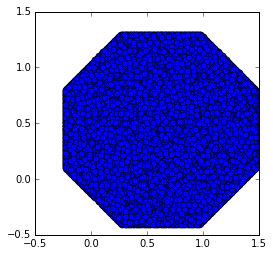

In [86]:
perp = 0.5*np.array([[sq2, -1., 0, 1], [0, 1, -sq2, 1]])

perppts = []
for p in posList:
    perppts.append(np.dot(perp, lift[p]))
perppts = np.array(perppts)

plt.plot(perppts[:,0], perppts[:,1], 'o')
plt.axes().set_aspect('equal')

In [115]:
X, Y = np.transpose(perppts)
Nsample=800j
grid_x, grid_y = np.mgrid[X.min():X.max():Nsample, Y.min():Y.max():Nsample]
#points = np.transpose(np.asarray([X,Y],dtype=np.float64 ))

#DATA = 
#Z = np.asarray(,dtype=np.float64)
#Z = np.array([np.array([p.real, p.imag]) for p in posList])
Z = data
# unpack the data in the order of Z
grid_z0 = griddata(perppts, Z, (grid_x, grid_y), method="cubic")

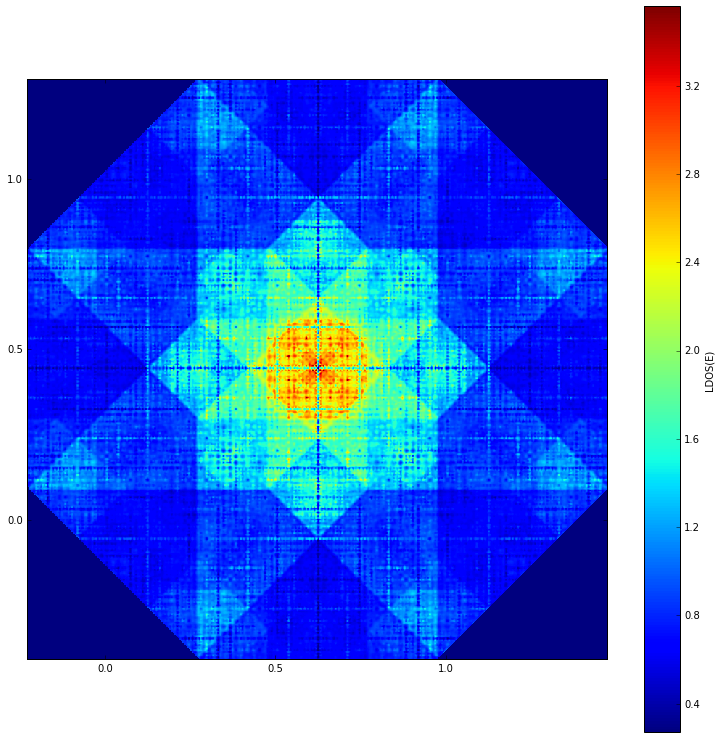

In [116]:
vmin= Z.min()
vmax= Z.max()
plt.imshow(np.nan_to_num(grid_z0).T, extent=(X.min(),X.max(),Y.min(),Y.max()), origin='lower',clim=(vmin,vmax),interpolation="none")
cb=plt.colorbar()
cb.set_label('LDOS(E)')
plt.savefig(name + '.pdf')

## Hamiltonian, electronic spectrum

In [8]:
# number of inflations
ninf = 4
# hamiltonian = adj mat, starting from a square
#h = square_a5.get_adjacency_matrix(square_a5.it_sub(square, ninf))
sparse = square_a5.get_sparse_adjacency(square_a5.it_sub(square, ninf))
#g = square_a5.get_graph(square_a5.it_sub(square, ninf))

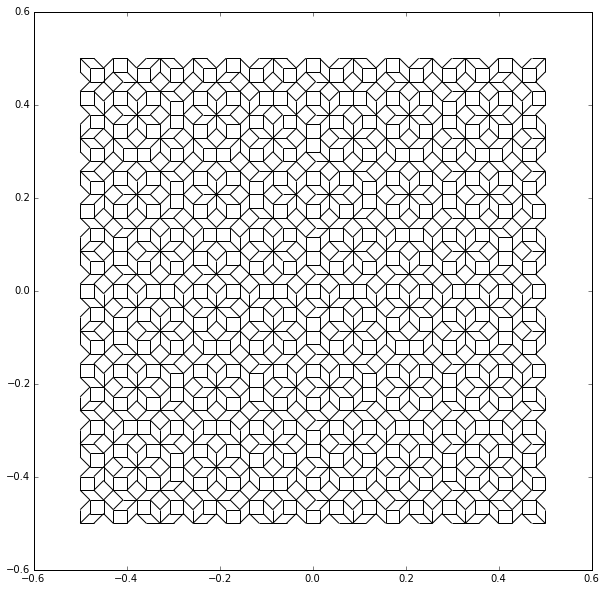

In [240]:
""" drawing the tiling """

# associated graph
g = square_a5.get_graph(square_a5.it_sub(square, ninf))
# convert to an networkx graph
G = nx.Graph(g)

# retrieve the node positions
list_pos = [(v.real, v.imag) for v in g.keys()]
# keys: nodes, entries: position of the nodes
dict_pos = dict(zip(g.keys(), list_pos))

# drawing!
nx.draw_networkx_edges(G, dict_pos)
plt.axes().set_aspect('equal')
plt.show()

In [241]:
""" electronic spectrum, open boundary conditions """

h = square_a5.get_adjacency_matrix(square_a5.it_sub(square, ninf))
val, vec = scipy.linalg.eigh(h)
#val = sort(val)

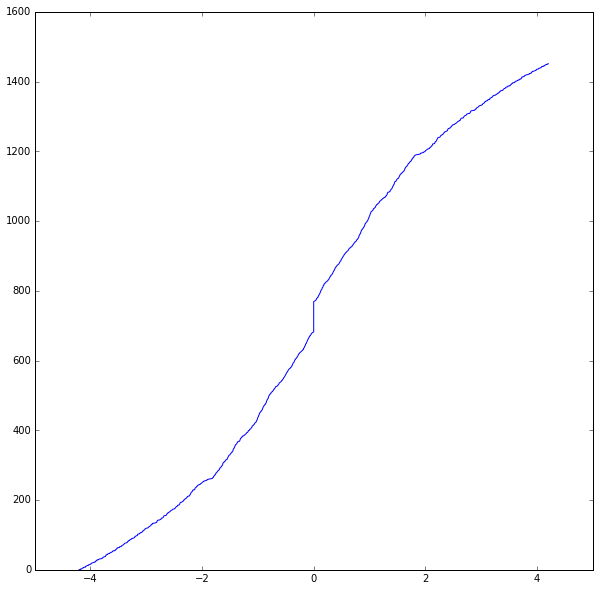

In [242]:
""" plotting idos """
L = len(val)
plt.plot(val, range(L))

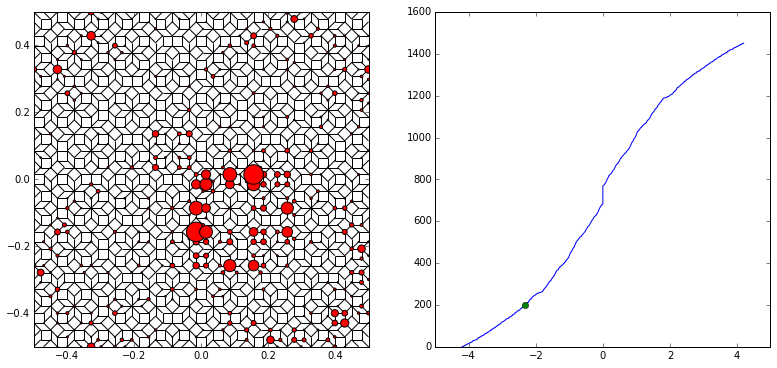

In [243]:
""" plotting a wavefunction """

# pick a wavefunction
state = 200
# syst size
L = len(val)
lb = sq2 - 1
# node size is function of the presence probability
prob = [10**3.5*L*abs(i)**4.2 for i in vec[:,state]]

# associated graph
g = square_a5.get_graph(square_a5.it_sub(square, ninf))
# convert to an networkx graph
G = nx.Graph(g)

# retrieve the node positions
list_pos = [(v.real, v.imag) for v in g.keys()]
# keys: nodes, entries: position of the nodes
dict_pos = dict(zip(g.keys(), list_pos))

l = 6
rcParams['figure.figsize'] = 2.2*l, l  # that's default image size for this interactive session

# drawing the crystal
plt.subplot(121)
nx.draw_networkx(G, dict_pos, node_size = prob, with_labels = False)
#plt.axes().set_aspect('equal')
xmin, xmax, ymin, ymax = -0.5, 0.5, -0.5, 0.5
plt.axis([xmin, xmax, ymin, ymax])

plt.subplot(122)
plt.plot(val, range(L), val[state], state, 'o')

plt.show()

## Lifting a tiling

In [7]:
""" start with a square made of two half-squares """

sq2 = math.sqrt(2)
# start with a square
square = []
# radius 
r = 1/sq2
# first half-square
C = cmath.rect(r, -math.pi/4)
A = cmath.rect(r, -3*math.pi/4)
B = cmath.rect(r, -5*math.pi/4)
square.append((r, (A, B, C)))
# second half-square
C = cmath.rect(r, -5*math.pi/4)
B = cmath.rect(r, -math.pi/4)
A = cmath.rect(r, math.pi/4)
square.append((r, (A, C, B)))

square_a5 = A5()

""" start with a lozenge """

lozenge = A5()
loz0 = [lozenge.get_prototiles()[0]]

""" start with a wheel """

wheel_a5 = A5()

# construct the wheel
wheel0 = []
sq2 = math.sqrt(2)
A = 0
for i in range(8):
    B = cmath.rect(1, (i) * math.pi / 4)
    D = cmath.rect(1, (i + 1) * math.pi / 4)
    C = B + D
    wheel0.append((0, (A, B, C, D)))
    
# half-squares

for i in range(8):
    C = cmath.rect(1, i * math.pi / 4)
    B = (1+sq2) * C
    A = cmath.rect(1, i * math.pi / 4) + cmath.rect(1, (i+1) * math.pi / 4)
    wheel0.append((1, (A, B, C)))
    
    A = cmath.rect(1, (i-1) * math.pi / 4) + cmath.rect(1, i * math.pi / 4)
    wheel0.append((1, (A, B, C)))

In [8]:
""" 
Takes a tiling (as a dict of positions:postitions of the neighbours), and returns its lift.
The lift_tiling function is abstract, and should work with any tiling. 
However the get_4D_vec function should only work with the tiles of the octogonal tiling.
horiz = 0 assumes that the squares are horizontal or inclined by pi/4.
"""

# returns the 4D vector connecting the lifts of p1 and p2, ie the vector e st e = lift(p2) - lift(p1)
# horiz a reference angle setting the orientation of the horizontal axis
def get_4D_vec(p1, p2, horiz):
    # list of 4D base vectors
    e = np.identity(4)
    
    # angle between vector p2 - p1 and the horizontal, ranging between -pi and pi
    th = cmath.phase(p2 - p1) - horiz
    # p1 -> p2 or p2 -> p1
    sgn = np.sign(th)
    
    # angles close to 0 or to +- pi are changed to +- 0
    if math.isclose(th, 0., abs_tol = 1e-09): 
        th = 0.
        sgn = 1
    elif math.isclose(abs(th), math.pi, abs_tol = 1e-09) or math.isclose(abs(th), -math.pi, abs_tol = 1e-09): 
        th = 0
        sgn = -1
        
    # transform the angle into an integer between 0 and 3
    coord = int(abs(np.round(th*4/math.pi)))

    if sgn >= 0:
        return e[coord]
    else:
        return -e[(4-coord)%4]

# lift tiling described by the position dictionary d
def lift_tiling(d, horiz):
    # point of the tiling that are already lifted
    liftedpts = set()
    
    # a dictionary linking pt of the tiling d to their lifts
    to4D = {}
            
    # lift non lifted neighbours of points of the list pts
    def lift_edges(pts):
        # new lifted points
        newpts = []
        for p in pts:
            # get coords of p in 4D
            p4D = to4D[p]
            # list non lifted neighbours of p
            neighs = d[p] - liftedpts
            # lift neighbour n
            for n in neighs:
                to4D[n] = p4D + get_4D_vec(p, n, horiz)
                newpts.append(n)
                liftedpts.add(n)
        
        if len(newpts) > 0:
            return lift_edges(newpts)

    # set the origin in 4D to an arbitrary point of d
    pt0 = list(d.keys())[0]
    lp0 = np.zeros(4)
    to4D[pt0] = lp0
    liftedpts.add(pt0)
    
    lift_edges([pt0])
    
    return to4D, liftedpts

In [9]:
""" Color edges according to their orientation and label sites with their 4D index. This is mainly for debugging. """

def color_edge(p1, p2, horiz):
    e = np.identity(4)
    vec = get_4D_vec(p1, p2, horiz)
    colorlist = ('r', 'g', 'b', 'black')
    for i in range(4):
        if np.dot(vec, e[i]) or np.dot(vec, -e[i]) : return colorlist[i]

# convert a vector (of integer elements) to a string
def to_string(vec):
    s = ''
    for el in vec:
        s += str(int(el))
    return s

In [12]:
ninf = 1

t = square_a5.it_sub(square, ninf)
g = square_a5.get_graph(t)

#t = lozenge.it_sub(loz0, ninf)
#g = lozenge.get_graph(t)

t = wheel_a5.it_sub(wheel0, ninf)
g = wheel_a5.get_graph(t)
square_a5.draw(t, (3000, 3000), .5)
square_a5.write_to_png("square.png")


lift, pts = lift_tiling(g, 0.)

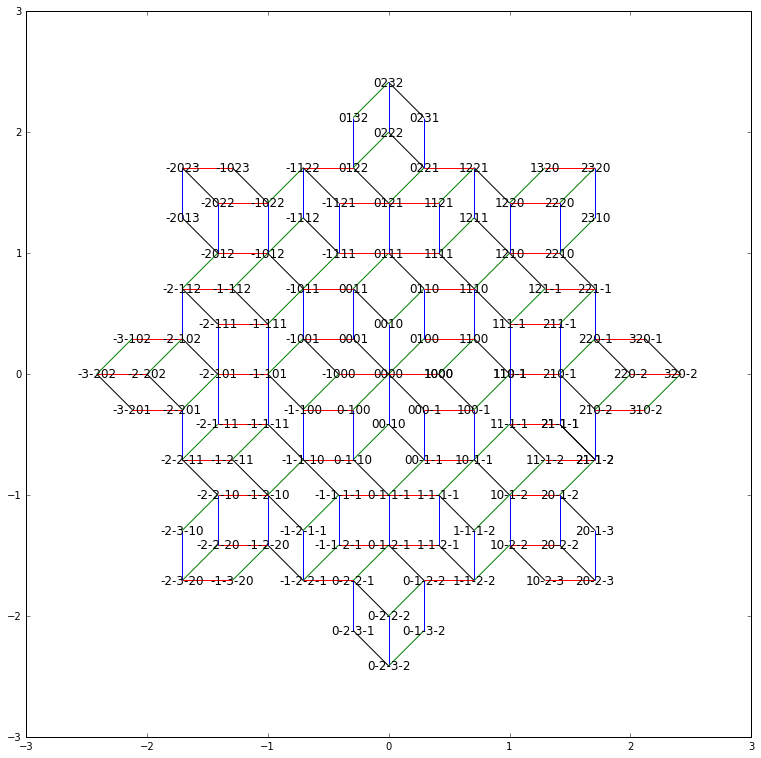

In [17]:
# convert to a networkx graph
G = nx.Graph(g)

# retrieve the node positions
list_pos = [(v.real, v.imag) for v in g.keys()]
# keys: nodes, entries: position of the nodes
dict_pos = dict(zip(g.keys(), list_pos))

# color edges according to their orientation
color_list = [ color_edge(ed[0], ed[1], 0.) for ed in G.edges() ]

# label sites according to their 4D position
label_list = { pt:to_string(lift[pt]) for pt in G.nodes() }

# drawing!
nx.draw_networkx(G, dict_pos, with_labels = True, edge_color = color_list, node_size = 0., labels = label_list)
xmin, xmax, ymin, ymax = -3., 3., -3., 3.
plt.axis([xmin, xmax, ymin, ymax])
plt.axes().set_aspect('equal')

In [12]:
perp = 0.5*np.array([[sq2, -1., 0, 1], [0, 1, -sq2, 1]])
para = 0.5*np.array([[sq2, 1., 0, -1], [0, 1, sq2, 1]])

In [13]:
# compute Octonacci numbers
def o(n):
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + 2*b
    return a

def perpn(n):
    r = o(n-1)/o(n)
    return np.array([[2, -(1 + r), 0, 1 + r], [0, 1 + r, -2, 1 + r]])/(2.*sq2)

In [14]:
perppts = []
for p in lift:
    perppts.append(np.dot(perpn(ninf), lift[p]))
perppts = np.array(perppts)

parapts = []
for p in lift:
    parapts.append(np.dot(para, lift[p]))
parapts = np.array(parapts)

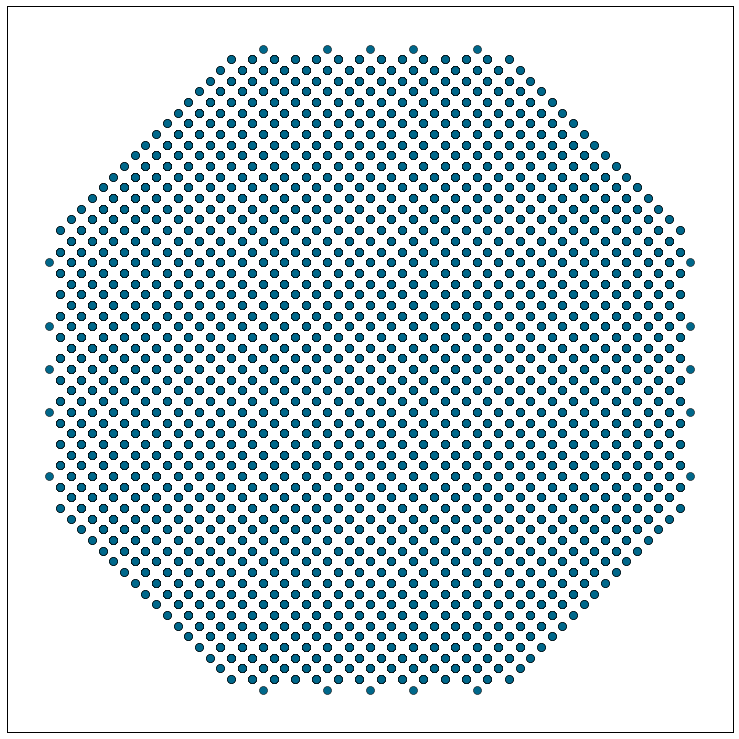

In [40]:
plt.plot(perppts[:,0], perppts[:,1], 'o', markersize=8., c='#00688B')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
    right='off',
    left='off',
    labelleft='off') # labels along the bottom edge are off
plt.axes().set_aspect('equal')
plt.savefig("ammann_beenker_perpspace.png")

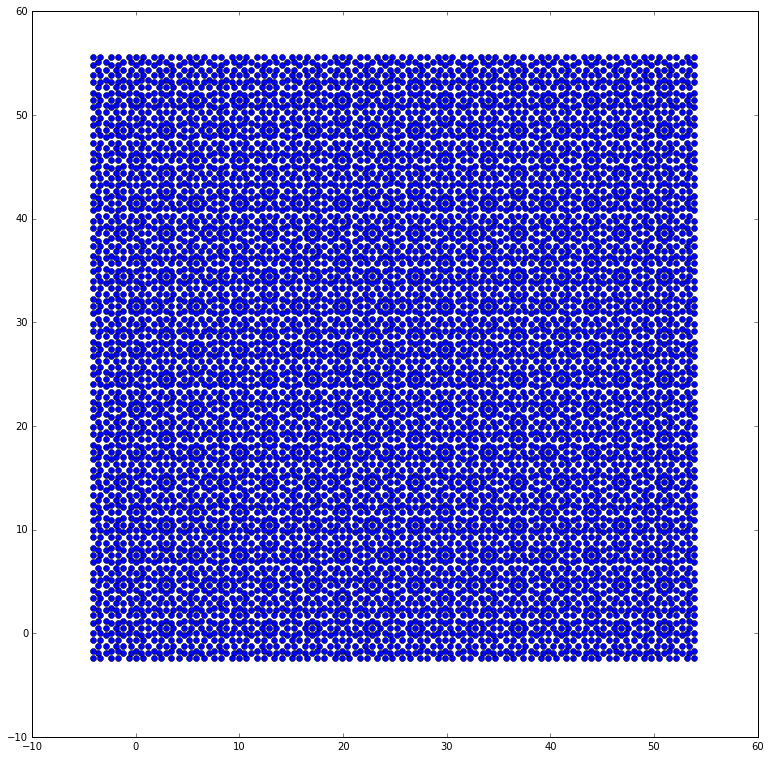

In [25]:
plt.plot(parapts[:,0], parapts[:,1], 'o')
plt.axes().set_aspect('equal')

## Shadows

In [10]:
# projection of vector v orthogonally to e
def proj(e, v):
    return v - np.dot(e, v)*e

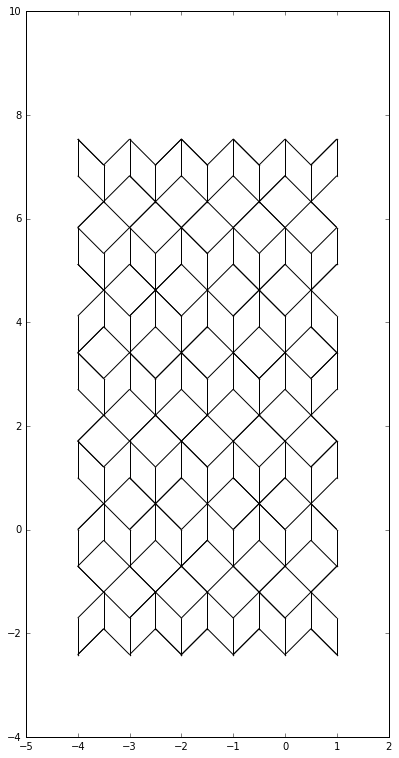

In [19]:
ninf = 3

t = square_a5.it_sub(square, ninf)
g = square_a5.get_graph(t)

#t = wheel_a5.it_sub(wheel0, ninf)
#g = wheel_a5.get_graph(t)

lift, pts = lift_tiling(g, 0.)

e = np.array([1,0,0,0]) # first projection vector
ee = np.array([0,0,0,0]) # second projection vector (to project the projection!)

# graph of the 4D surface
g4D = {tuple(lift[p]):{tuple(lift[n]) for n in  g[p]} for p in g}

# convert to a networkx graph
G = nx.Graph(g4D)

# keys: nodes, entries: position of the nodes
dict_pos = {v:np.dot(para, proj(ee, proj(e,v))) for v in g4D}

# drawing!
nx.draw_networkx(G, dict_pos, with_labels = False, node_size = 0.1)
xmin, xmax, ymin, ymax = -3., 3., -3., 3.
#lt.axis([xmin, xmax, ymin, ymax])
plt.axes().set_aspect('equal')
plt.savefig('shadow.pdf')